Forest fire model captures emergence of order from independent actions, yet interdependent outcomes. Here, we will step by step introduce more complexity to the Forest Fire model following Miller and Page (2009). While their description of the model offers some visualizations, we will dive deeper into some other formal outcomes of the model.

In [169]:
# All we need is numpy library for mathematical operations and pyplot module from matplotlib for visualization
import numpy as np
import matplotlib.pyplot as plt

# Defining a function returning running mean of N time steps for visualization
def running_mean(x, N):
    csum = np.cumsum(np.insert(x, 0, 0)) 
    return (csum[N:] - csum[:-N]) / float(N)

First, we start with defining a growth function. Below, the inputs are a list of locations where there are grown trees and a vector of locations with 0 if no tree and 1 if tree present. Finally, a vector of growthrates for each location.

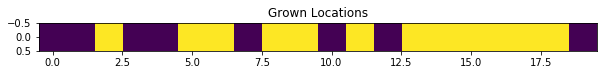

Locations with grown trees: [2, 5, 6, 8, 9, 11, 13, 14, 15, 16, 17, 18]


In [200]:
def grow(grown,grd,growthrate):
    global N
    for n in range(N):
        if not n in grown:
            if np.random.binomial(1,growthrate[n]):
                grown.append(n)
                grd[n] = 1
    return grown,grd

N = 20
grown, grd = grow([],np.zeros(N),np.ones(N)*0.5) # List of locations of grown trees and vector for tree states
plt.figure(figsize=(10,5))
plt.title('Grown Locations')
plt.imshow(np.expand_dims(grd,0))
plt.show()
print('Locations with grown trees: ' + str(grown))

Next, we define a lightning strike function. This functions takes as input the locations of grown trees and a strike rate (f). If there is a tree in a given location, a lightning strikes with probability f.

In [202]:
def strike(grown,grd,strikerate):
    global N
    struck = np.zeros(N)
    fires = []
    for n in grown:
        fire = 0
        if grd[n] and np.random.binomial(1,strikerate) and not(struck[n]):
            struck[n] = 1
            s = 0
            while n+s+1<N and grd[n+s+1]:
                struck[n+s+1] = 1
                s += 1
            fire += s
            s = 0
            while n-s>=0 and grd[n-s]:
                struck[n-s] = 1
                s += 1
            fires.append(fire+s)
    return struck,fires

struck, fires = strike(grown,grd,0.5) # Vector for trees that are struck and list of fire sizes
plt.figure(figsize=(10,5))
plt.title('Struck Locations')
plt.imshow(np.expand_dims(struck,0))
plt.show()
print('Fire sizes: '+str(fires))

Fire sizes: [2, 1, 6]


Following a step of growth and strike, we see that some trees survive (green) and some others burn down (yellow).

Reproducing Table 7.2


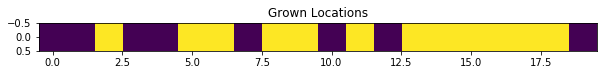

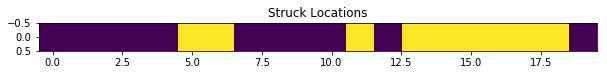

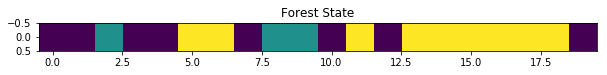

Yellow locations are fires. Green locations are surviving trees.


In [203]:
print('Reproducing Table 7.2')

plt.figure(figsize=(10,5))
plt.title('Grown Locations')
plt.imshow(np.expand_dims(grd,0))
plt.show()

plt.figure(figsize=(10,5))
plt.title('Struck Locations')
plt.imshow(np.expand_dims(struck,0))
plt.show()

plt.figure(figsize=(10,5))
plt.title('Forest State')
plt.imshow(np.expand_dims(grd+struck,0))
plt.show()
print('Yellow locations are fires. Green locations are surviving trees.')

Now if we repeat this cycle 250 times for 100 trees, we observe the image below.

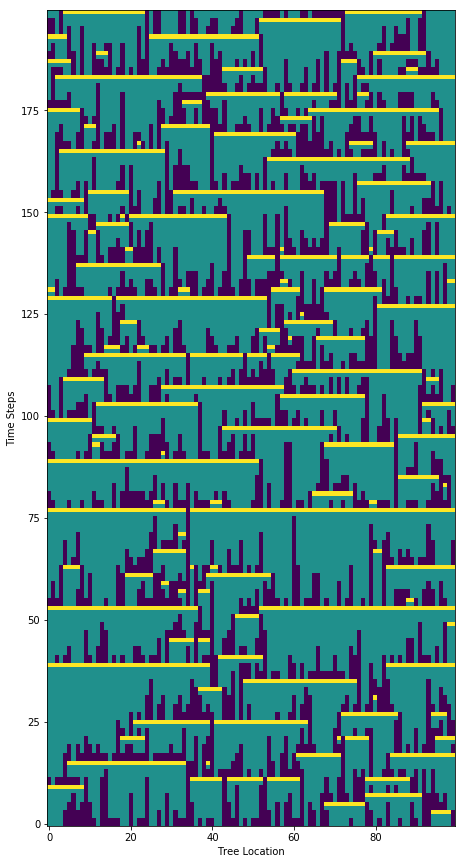

In [301]:
N = 100 # Number of trees
T = 500 # Time steps
f = 0.02 # Fire striking probability

g = np.ones(N)*0.4 # Growth rate

tree_numbers = np.zeros(T) # Average number of trees
tree_states = np.zeros((N,T)) # State of trees

grown = [] # List of locations of grown trees
grd = np.zeros(N) # Initial vector for tree states

struck = np.zeros(N) # Vector for trees that are struck
fire_sizes = []

for t in range(T):
    if (1+t)%2: # Growth phase
        grown,grd = grow(grown,grd,g)
        tree_states[:,t] = grd.copy()
    else: # Strike phase
        struck,fires = strike(grown,grd,f)
        tree_states[:,t] = grd.copy()+struck.copy()
        
        grd = (tree_states[:,t].copy())%2 # Taking module 2 returns burnt trees back to state 0.
        grown = np.nonzero(grd)[0].tolist() # Updating grown trees list
        tree_numbers[t] += np.mean(grd)
        fire_sizes += fires
        
plt.figure(figsize=(13,15))
plt.imshow(tree_states[:,:200].transpose(),origin='lower')
plt.ylabel('Time Steps')
plt.xlabel('Tree Location')
plt.show()

We can further analyze the distribution of forest fire sizes and the average number of trees present following each cycle.

We observe a forest fire size distribution that is power law with mean: 12.68
Average number of trees present at a given time is: 0.59


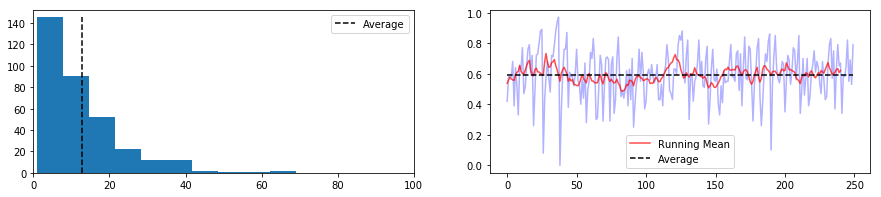

In [302]:
fig,axs = plt.subplots(1,2,figsize=(15,3))

hst = axs[0].hist(fire_sizes)
average = np.dot(hst[0],(hst[1][1:]+hst[1][:-1])/2)/np.sum(hst[0])
print('We observe a forest fire size distribution that is power law with mean: {}'.format(round(average,2)))
axs[0].plot([average]*2,[0,max(hst[0])],'k--',label='Average')
axs[0].set_xlim((0,100))
axs[0].legend()

axs[1].plot(tree_numbers[1::2],'b',alpha=0.3)
axs[1].plot(running_mean(tree_numbers[1::2],10),'r',alpha=0.7,label='Running Mean')
average = np.mean(tree_numbers[1::2])
axs[1].plot(np.ones(len(tree_numbers[1::2]))*average,'k--',label='Average')
print('Average number of trees present at a given time is: {}'.format(round(average,2)))
axs[1].legend()
plt.show()

To reproduce the figure 7.1, we set the growth rate for each simulation differently and look at the average number of trees after each cycle.

In [312]:
rounds = 20

N = 100 # Number of trees
T = 500 # Time steps
f = 0.02 # Fire striking probability

growth_rates = np.arange(1,10.5,0.5)/10 # Growth rates going from 0.1 to 1.0 in 0.05 steps
average_forestsize = np.zeros(len(growth_rates))

for _ in range(rounds):
    for i,growth_rate in enumerate(growth_rates):
        g = np.ones(N)*growth_rate # Growth rate
        tree_numbers = np.zeros(T) # Average number of trees
        tree_states = np.zeros((N,T)) # State of trees
        grown = [] # List of locations of grown trees
        grd = np.zeros(N) # Initial vector for tree states
        struck = np.zeros(N) # Vector for trees that are struck

        for t in range(T):
            if (1+t)%2: # Growth phase
                grown,grd = grow(grown,grd,g)
                tree_states[:,t] = grd.copy()
            else: # Strike phase
                struck,fires = strike(grown,grd,f)
                tree_states[:,t] = grd.copy()+struck.copy()

                grd = (tree_states[:,t].copy())%2 # Taking module 2 returns burnt trees back to state 0.
                grown = np.nonzero(grd)[0].tolist() # Updating grown trees list
                tree_numbers[t] += np.mean(grd)
                fire_sizes += fires
        average_forestsize[i] += np.mean(tree_numbers[1::2])/rounds
    

print('Reproducing Figure 7.1')
print('Maximum average tree number of {} is achieved at {}'.format(max(average_forestsize),
                                                                   growth_rates[np.argmax(average_forestsize)]))
plt.plot(growth_rates,average_forestsize)
plt.ylim([0,0.7])
plt.ylabel('Average Tree Number')
plt.xlabel('Growth Rate')
plt.show()

Reproducing Figure 7.1
Maximum average tree number of 0.592432 is achieved at 0.45


For next chapter, we introduce two forms of selection. One is simply selecting out the low-growth trees (grow with selection). The other is the tree is replaced if it is struck. We see that second choice aligns with the statement in the book, whereas the second one leads to a different outcome

In [305]:
def grow_withselection(grown,grd,growthrate,selection = 0):
    global N
    for n in range(N):
        if not n in grown:
            if np.random.binomial(1,growthrate[n]):
                grown.append(n)
                grd[n] = 1
    if selection:
        av_growth,std_growth = np.mean(growthrate),np.std(growthrate)
        g = growthrate.copy()
        for n in range(len(growthrate)):
            if g[n] < av_growth-std_growth:
                g[n] = np.random.uniform(0,1)
        return grown,grd,g
    return grown,grd

def strike_withselection(grown,grd,strikerate,selection = 0,growthrate = np.zeros(1)):
    global N
    struck = np.zeros(N)
    fires = []
    for n in grown:
        fire = 0
        if grd[n] and np.random.binomial(1,strikerate) and not(struck[n]):
            struck[n] = 1
            s = 0
            while n+s+1<N and grd[n+s+1]:
                struck[n+s+1] = 1
                s += 1
            fire += s
            s = 0
            while n-s>=0 and grd[n-s]:
                struck[n-s] = 1
                s += 1
            fires.append(fire+s)
    if selection:
        g = growthrate.copy()
        for n in range(len(struck)):
            if struck[n]:
                g[n] = np.random.uniform(0,1)
        return struck,fires,g
    return struck,fires

In [306]:
rounds = 20

N = 100 # Number of trees
T = 1000 # Time steps
f = 0.02 # Fire striking probability
print('Implications of chapter 7.2.3')
fig,axs = plt.subplots(1,2,figsize = (15,3))

growth_rates = np.zeros(T)
average_forestsize = np.zeros(len(growth_rates))
for _ in range(rounds):
    g = np.random.uniform(0,0.5,N) # Growth rate
    tree_numbers = np.zeros(T) # Average number of trees
    tree_states = np.zeros((N,T)) # State of trees
    grown = [] # List of locations of grown trees
    grd = np.zeros(N) # Initial vector for tree states
    struck = np.zeros(N) # Vector for trees that are struck

    for t in range(T):
        growth_rates[t] += np.mean(g)/rounds
        if (1+t)%2: # Growth phase
            grown,grd,g = grow_withselection(grown,grd,g,selection = 1)
            tree_states[:,t] = grd.copy()
        else: # Strike phase
            struck,fires = strike_withselection(grown,grd,f)
            tree_states[:,t] = grd.copy()+struck.copy()

            grd = (tree_states[:,t].copy())%2 # Taking module 2 returns burnt trees back to state 0.
            grown = np.nonzero(grd)[0].tolist() # Updating grown trees list
            tree_numbers[t] += np.mean(grd)
            fire_sizes += fires
    growth_rates[-1] += np.mean(g)/rounds
    
axs[0].plot(growth_rates[::2],'b',label='Selection by fitness')
axs[1].plot(running_mean(tree_numbers[1::2],10),'b',label='Selection by fitness')

growth_rates = np.zeros(T)
average_forestsize = np.zeros(len(growth_rates))
for _ in range(rounds):
    g = np.random.uniform(0,0.5,N) # Growth rate
    tree_numbers = np.zeros(T) # Average number of trees
    tree_states = np.zeros((N,T)) # State of trees
    grown = [] # List of locations of grown trees
    grd = np.zeros(N) # Initial vector for tree states
    struck = np.zeros(N) # Vector for trees that are struck

    for t in range(T):
        growth_rates[t] += np.mean(g)/rounds
        if (1+t)%2: # Growth phase
            grown,grd = grow_withselection(grown,grd,g)
            tree_states[:,t] = grd.copy()
        else: # Strike phase
            struck,fires,g = strike_withselection(grown,grd,f,selection = 1,growthrate = g)
            tree_states[:,t] = grd.copy()+struck.copy()

            grd = (tree_states[:,t].copy())%2 # Taking module 2 returns burnt trees back to state 0.
            grown = np.nonzero(grd)[0].tolist() # Updating grown trees list
            tree_numbers[t] += np.mean(grd)
            fire_sizes += fires
    growth_rates[-1] += np.mean(g)/rounds
    
axs[0].plot(growth_rates[::2],'r',label='Selection if struck')
axs[1].plot(running_mean(tree_numbers[1::2],10),'r',label='Selection if struck')

axs[0].set_ylim((0,1.0))
axs[1].set_ylim((0,1.0))

axs[0].set_ylabel('Average Growth Rate')
axs[1].set_ylabel('Average Tree Number')

plt.legend()
plt.show()
    

Implications of chapter 7.2.3


Finally, we would like to understand how independent adaptation affects the overall dynamics. Reinforcement parameter determines whether the learning is through reinforcement or simply linear increments.

In [355]:
def strike_withadaptation(grown,grd,strikerate,growthrate):
    global N
    struck = np.zeros(N)
    fires = []
    for n in grown:
        fire = 0
        if grd[n] and np.random.binomial(1,strikerate) and not(struck[n]):
            struck[n] = 1
            s = 0
            while n+s+1<N and grd[n+s+1]:
                struck[n+s+1] = 1
                s += 1
            fire += s
            s = 0
            while n-s>=0 and grd[n-s]:
                struck[n-s] = 1
                s += 1
            fires.append(fire+s)
            
    g = growthrate.copy()
    for n in range(N):
        if grd[n]:
            if struck[n]:
                g[n] -= 0.01
                if g[n]<0:
                    g[n] = 0
            else:
                g[n] += 0.01
                if g[n]>1.0:
                    g[n] = 1.0
    
    return struck,fires,g

You can observe the corridors of low growth rate in the figure on the right.

In [356]:
N = 100 # Number of trees
T = 1000 # Time steps
f = 0.02 # Fire striking probability

g = np.random.uniform(0,1,N) # Growth rate

tree_numbers = np.zeros(T) # Average number of trees
growth_rates = np.zeros((N,T)) # Growth rates
tree_states = np.zeros((N,T)) # State of trees

grown = [] # List of locations of grown trees
grd = np.zeros(N) # Initial vector for tree states

struck = np.zeros(N) # Vector for trees that are struck
fire_sizes = []

for t in range(T):
    growth_rates[:,t] += g.copy()
    if (1+t)%2: # Growth phase
        grown,grd = grow(grown,grd,g)
        tree_states[:,t] = grd.copy()
        
    else: # Strike phase
        struck,fires,g = strike_withadaptation(grown,grd,f,g)
        if max(struck)>1 or max(grd)>1:
            print(t,struck,grd)
        tree_states[:,t] += grd.copy()+struck.copy()
            
        grd = (tree_states[:,t].copy())%2 # Taking module 2 returns burnt trees back to state 0.
        grown = np.nonzero(grd)[0].tolist() # Updating grown trees list
        tree_numbers[t] += np.mean(grd)
        fire_sizes += fires
growth_rates[:,-1] += g.copy()

fix,axs = plt.subplots(1,2,figsize=(15,15))
axs[0].imshow(tree_states[:,:].transpose(),origin='lower',aspect='auto')
axs[0].set_title('Tree State')
axs[0].set_ylabel('Time Steps')
axs[0].set_xlabel('Tree Location')

axs[1].imshow(growth_rates[:,1:-2:2].transpose(),origin='lower',aspect='auto')
axs[1].set_title('Growth Rate')
axs[1].set_ylabel('Time Steps')
axs[1].set_xlabel('Tree Location')
plt.show()

Average forest fire size has increased, but the shape is not power law anymore.

In [357]:
fig,axs = plt.subplots(1,3,figsize=(15,3))

hst = axs[0].hist(fire_sizes)
average = np.dot(hst[0],(hst[1][1:]+hst[1][:-1])/2)/np.sum(hst[0])
print('We observe a forest fire size distribution with mean: {}'.format(round(average,2)))
axs[0].plot([average]*2,[0,max(hst[0])],'k--',label='Average')
axs[0].set_xlabel('Forest Fire Size')
axs[0].set_xlim((0,100))
axs[0].legend()

axs[1].plot(tree_numbers[1::2],'b',alpha=0.3)
axs[1].plot(running_mean(tree_numbers[1::2],10),'r',alpha=0.7,label='Running Mean')
average = np.mean(tree_numbers[1::2])
axs[1].plot(np.ones(len(tree_numbers[1::2]))*average,'k--',label='Average')
print('Average number of trees present at a given time is: {}'.format(round(average,2)))
axs[1].legend()

axs[2].plot(np.mean(growth_rates[:,1:-2:2],0),'b')
plt.show()

We observe a forest fire size distribution with mean: 20.39
Average number of trees present at a given time is: 0.62


We observe that those who started with low growth rates, remain low in the long run. This points at a reinforcement loop, a form of winner takes all (or loser looses all). This is because those which get to grow fast already create high risk for fires that spread out, leading to no chance for low growth rate trees to grow further.

In [358]:
plt.scatter(growth_rates[:,0],growth_rates[:,-3])
plt.xlabel('Initial Growth Rate')
plt.ylabel('Final Growth Rate')
plt.show()